## Copy molecule=protein, ksize=21, log2sketchsize=12 data to here

In [61]:
%load_ext autoreload
%autoreload 2


# Python standard library
import os
import glob
import itertools

import tempfile


# 3rd party libraries
import pandas as pd
from sourmash.signature import load_signatures
from tqdm import tqdm

from joblib import Parallel, delayed, load, dump

# Local handwritten library
import khtools
from khtools import idf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
! aws s3 ls s3://kmer-hashing/hematopoeisis/human_mouse_zebrafish/sketches/ | tail

                           PRE molecule-protein_ksize-15_log2sketchsize-14/
                           PRE molecule-protein_ksize-15_log2sketchsize-16/
                           PRE molecule-protein_ksize-21_log2sketchsize-10/
                           PRE molecule-protein_ksize-21_log2sketchsize-12/
                           PRE molecule-protein_ksize-21_log2sketchsize-14/
                           PRE molecule-protein_ksize-9_log2sketchsize-10/
                           PRE molecule-protein_ksize-9_log2sketchsize-12/
                           PRE molecule-protein_ksize-9_log2sketchsize-14/
                           PRE molecule-protein_ksize-9_log2sketchsize-16/
                           PRE null/


In [5]:
!aws s3 ls s3://kmer-hashing/hematopoeisis/human_mouse_zebrafish/sketches/null/

2019-04-10 11:32:32      34345 A1-B001717-3_38_F-1-1.sig
2019-04-10 11:32:32      34398 A10-B002775-3_39_F-1-1.sig
2019-04-10 11:32:32      34600 A10-MAA000752-3_10_M-1-1.sig
2019-04-10 11:32:32      34747 A11-MAA000801-3_11_M-1-1.sig
2019-04-10 11:32:32      34205 A12-B001717-3_38_F-1-1.sig
2019-04-10 11:32:32      34698 A12-MAA000801-3_11_M-1-1.sig
2019-04-10 11:32:32      34539 A12-MAA000922-3_9_M-1-1.sig
2019-04-10 11:32:32      34328 A13-B001717-3_38_F-1-1.sig
2019-04-10 11:32:32      34806 A13-MAA000545-3_8_M-1-1.sig
2019-04-10 11:32:32      34744 A14-B001717-3_38_F-1-1.sig
2019-04-10 11:32:32      34962 A14-B002775-3_39_F-1-1.sig
2019-04-10 11:32:32      34877 A14-MAA000545-3_8_M-1-1.sig
2019-04-10 11:32:32      34796 A14-MAA000801-3_11_M-1-1.sig
2019-04-10 11:32:32      34836 A15-B001717-3_38_F-1-1.sig
2019-04-10 11:32:32      34800 A15-B002775-3_39_F-1-1.sig
2019-04-10 11:32:32      34895 A15-MAA000801-3_11_M-1-1.sig
2019-04-10 11:32:32      34918 A16-MAA000545-3_8_M-1-1.sig
2

2019-04-10 11:32:34      34432 H1-MAA000801-3_11_M-1-1.sig
2019-04-10 11:32:34      33898 H10-MAA000801-3_11_M-1-1.sig
2019-04-10 11:32:34      34315 H12-B001717-3_38_F-1-1.sig
2019-04-10 11:32:35      34076 H12-MAA000801-3_11_M-1-1.sig
2019-04-10 11:32:35      34398 H14-B001717-3_38_F-1-1.sig
2019-04-10 11:32:35      34703 H15-B001717-3_38_F-1-1.sig
2019-04-10 11:32:35      34711 H16-B001717-3_38_F-1-1.sig
2019-04-10 11:32:35      34046 H16-MAA000752-3_10_M-1-1.sig
2019-04-10 11:32:35      34117 H16-MAA000801-3_11_M-1-1.sig
2019-04-10 11:32:35      34950 H17-B001717-3_38_F-1-1.sig
2019-04-10 11:32:35      34655 H18-B001717-3_38_F-1-1.sig
2019-04-10 11:32:35      34864 H19-MAA000801-3_11_M-1-1.sig
2019-04-10 11:32:35      34777 H2-MAA000545-3_8_M-1-1.sig
2019-04-10 11:32:35      34238 H20-MAA000752-3_10_M-1-1.sig
2019-04-10 11:32:35      33878 H20-MAA000801-3_11_M-1-1.sig
2019-04-10 11:32:35      34438 H21-MAA000752-3_10_M-1-1.sig
2019-04-10 11:32:35      34639 H4-B001717-3_38_F-1-1.si

2019-04-10 11:32:39      33975 SRR4050385_pass.sig
2019-04-10 11:32:39      34392 SRR4050386_pass.sig
2019-04-10 11:32:39      33829 SRR4050387_pass.sig
2019-04-10 11:32:39      34369 SRR4050388_pass.sig
2019-04-10 11:32:39      33834 SRR4050389_pass.sig
2019-04-10 11:32:39      34037 SRR4050390_pass.sig
2019-04-10 11:32:39      34153 SRR4050391_pass.sig
2019-04-10 11:32:39      33847 SRR4050392_pass.sig
2019-04-10 11:32:39      34183 SRR4050393_pass.sig
2019-04-10 11:32:39      34385 SRR4050394_pass.sig
2019-04-10 11:32:39      34178 SRR4050395_pass.sig
2019-04-10 11:32:39      34206 SRR4050396_pass.sig
2019-04-10 11:32:39      34128 SRR4050397_pass.sig
2019-04-10 11:32:39      34153 SRR4050398_pass.sig
2019-04-10 11:32:39      33831 SRR4050399_pass.sig
2019-04-10 11:32:39      33968 SRR4050400_pass.sig
2019-04-10 11:32:39      34063 SRR4050401_pass.sig
2019-04-10 11:32:39      34296 SRR4050402_pass.sig
2019-04-10 11:32:39      34357 SRR4050403_pass.sig
2019-04-10 11:32:39      34511 

2019-04-10 11:32:43      34524 SRR4050699_pass.sig
2019-04-10 11:32:43      34343 SRR4050700_pass.sig
2019-04-10 11:32:43      34037 SRR4050701_pass.sig
2019-04-10 11:32:43      34227 SRR4050702_pass.sig
2019-04-10 11:32:43      34625 SRR4050703_pass.sig
2019-04-10 11:32:43      34316 SRR4050704_pass.sig
2019-04-10 11:32:43      34241 SRR4050705_pass.sig
2019-04-10 11:32:43      34444 SRR4050706_pass.sig
2019-04-10 11:32:43      34234 SRR4050707_pass.sig
2019-04-10 11:32:43      34146 SRR4050708_pass.sig
2019-04-10 11:32:43      34543 SRR4050709_pass.sig
2019-04-10 11:32:43      34373 SRR4050710_pass.sig
2019-04-10 11:32:43      34368 SRR4050711_pass.sig
2019-04-10 11:32:43      34530 SRR4050712_pass.sig
2019-04-10 11:32:43      34299 SRR4050713_pass.sig
2019-04-10 11:32:43      34156 SRR4050714_pass.sig
2019-04-10 11:32:44      34644 SRR4050715_pass.sig
2019-04-10 11:32:44      34338 SRR4050716_pass.sig
2019-04-10 11:32:44      34345 SRR4050717_pass.sig
2019-04-10 11:32:44      34523 

2019-04-10 11:32:46      34458 SRR4050860_pass.sig
2019-04-10 11:32:46      34678 SRR4050861_pass.sig
2019-04-10 11:32:46      34512 SRR4050862_pass.sig
2019-04-10 11:32:46      34604 SRR4050863_pass.sig
2019-04-10 11:32:46      34134 SRR4050864_pass.sig
2019-04-10 11:32:46      34428 SRR4050865_pass.sig
2019-04-10 11:32:46      34346 SRR4050866_pass.sig
2019-04-10 11:32:46      34298 SRR4050867_pass.sig
2019-04-10 11:32:46      34396 SRR4050868_pass.sig
2019-04-10 11:32:46      34242 SRR4050869_pass.sig
2019-04-10 11:32:46      34361 SRR4050870_pass.sig
2019-04-10 11:32:46      34129 SRR4050871_pass.sig
2019-04-10 11:32:46      34178 SRR4050872_pass.sig
2019-04-10 11:32:46      34382 SRR4050873_pass.sig
2019-04-10 11:32:46      34302 SRR4050874_pass.sig
2019-04-10 11:32:46      34173 SRR4050875_pass.sig
2019-04-10 11:32:46      34361 SRR4050876_pass.sig
2019-04-10 11:32:46      34157 SRR4050877_pass.sig
2019-04-10 11:32:46      34435 SRR4050878_pass.sig
2019-04-10 11:32:46      34496 

2019-04-10 11:32:49      34815 SRR4051078_pass.sig
2019-04-10 11:32:49      34386 SRR4051079_pass.sig
2019-04-10 11:32:49      34600 SRR4051080_pass.sig
2019-04-10 11:32:49      34676 SRR4051081_pass.sig
2019-04-10 11:32:49      34107 SRR4051082_pass.sig
2019-04-10 11:32:49      34657 SRR4051083_pass.sig
2019-04-10 11:32:49      34685 SRR4051084_pass.sig
2019-04-10 11:32:49      34093 SRR4051085_pass.sig
2019-04-10 11:32:49      34459 SRR4051086_pass.sig
2019-04-10 11:32:49      34070 SRR4051087_pass.sig
2019-04-10 11:32:49      34729 SRR4051088_pass.sig
2019-04-10 11:32:49      33937 SRR4051089_pass.sig
2019-04-10 11:32:49      34727 SRR4051090_pass.sig
2019-04-10 11:32:49      34363 SRR4051091_pass.sig
2019-04-10 11:32:49      34291 SRR4051092_pass.sig
2019-04-10 11:32:49      34433 SRR4051093_pass.sig
2019-04-10 11:32:49      34141 SRR4051094_pass.sig
2019-04-10 11:32:49      34331 SRR4051095_pass.sig
2019-04-10 11:32:49      34419 SRR4051096_pass.sig
2019-04-10 11:32:49      34088 

2019-04-10 11:32:53      34548 SRR4052960_pass.sig
2019-04-10 11:32:53      34133 SRR4052961_pass.sig
2019-04-10 11:32:53      34061 SRR4052962_pass.sig
2019-04-10 11:32:53      34182 SRR4052963_pass.sig
2019-04-10 11:32:53      34287 SRR4052964_pass.sig
2019-04-10 11:32:53      34288 SRR4052965_pass.sig
2019-04-10 11:32:53      34556 SRR4052966_pass.sig
2019-04-10 11:32:53      34258 SRR4052967_pass.sig
2019-04-10 11:32:53      33975 SRR4052968_pass.sig
2019-04-10 11:32:53      36144 SRR4052969_pass.sig
2019-04-10 11:32:53      34136 SRR4052970_pass.sig
2019-04-10 11:32:53      34128 SRR4052971_pass.sig
2019-04-10 11:32:53      34748 SRR4052972_pass.sig
2019-04-10 11:32:53      34117 SRR4052973_pass.sig
2019-04-10 11:32:53      34586 SRR4052974_pass.sig
2019-04-10 11:32:53      34582 SRR4052975_pass.sig
2019-04-10 11:32:53      33830 SRR4052976_pass.sig
2019-04-10 11:32:53      34202 SRR4052977_pass.sig
2019-04-10 11:32:53      34364 SRR4052978_pass.sig
2019-04-10 11:32:53      34104 

2019-04-10 11:32:58      34917 SRR5810744_pass.sig
2019-04-10 11:32:58      34958 SRR5810745_pass.sig
2019-04-10 11:32:58      34988 SRR5810746_pass.sig
2019-04-10 11:32:58      34930 SRR5810747_pass.sig
2019-04-10 11:32:58      34885 SRR5810748_pass.sig
2019-04-10 11:32:58      34950 SRR5810749_pass.sig
2019-04-10 11:32:58      34930 SRR5810750_pass.sig
2019-04-10 11:32:58      34839 SRR5810751_pass.sig
2019-04-10 11:32:58      34894 SRR5810752_pass.sig
2019-04-10 11:32:58      35953 SRR5810753_pass.sig
2019-04-10 11:32:58      34900 SRR5810754_pass.sig
2019-04-10 11:32:58      34778 SRR5810755_pass.sig
2019-04-10 11:32:58      35849 SRR5810756_pass.sig
2019-04-10 11:32:58      34978 SRR5810757_pass.sig
2019-04-10 11:32:58      34982 SRR5810758_pass.sig
2019-04-10 11:32:58      34935 SRR5810759_pass.sig
2019-04-10 11:32:58      35145 SRR5810760_pass.sig
2019-04-10 11:32:58      34911 SRR5810761_pass.sig
2019-04-10 11:32:58      34971 SRR5810762_pass.sig
2019-04-10 11:32:58      34963 

2019-04-10 11:33:00      34811 SRR5810905_pass.sig
2019-04-10 11:33:00      34742 SRR5810906_pass.sig
2019-04-10 11:33:00      34641 SRR5810907_pass.sig
2019-04-10 11:33:00      34652 SRR5810908_pass.sig
2019-04-10 11:33:00      34742 SRR5810909_pass.sig
2019-04-10 11:33:00      34619 SRR5810910_pass.sig
2019-04-10 11:33:00      34475 SRR5810911_pass.sig
2019-04-10 11:33:00      34900 SRR5810912_pass.sig
2019-04-10 11:33:00      34807 SRR5810913_pass.sig
2019-04-10 11:33:00      34457 SRR5810914_pass.sig
2019-04-10 11:33:00      34657 SRR5810915_pass.sig
2019-04-10 11:33:00      34956 SRR5810916_pass.sig
2019-04-10 11:33:00      34623 SRR5810917_pass.sig
2019-04-10 11:33:00      34954 SRR5810918_pass.sig
2019-04-10 11:33:00      34997 SRR5810919_pass.sig
2019-04-10 11:33:00      34767 SRR5810920_pass.sig
2019-04-10 11:33:00      34400 SRR5810921_pass.sig
2019-04-10 11:33:00      34728 SRR5810922_pass.sig
2019-04-10 11:33:00      36069 SRR5810923_pass.sig
2019-04-10 11:33:00      35447 

In [ ]:
suffix = 'kmer-hashing/hematopoeisis/human_mouse_zebrafish/sketches/molecule-protein_ksize-21_log2sketchsize-12/'

In [7]:
! aws s3 ls s3://$suffix | head

2019-04-10 11:24:50    1297332 A1-B001717-3_38_F-1-1.sig
2019-04-10 11:24:50    1297632 A10-B002775-3_39_F-1-1.sig
2019-04-10 11:24:50    1298050 A10-MAA000752-3_10_M-1-1.sig
2019-04-10 11:24:50    1297936 A11-MAA000801-3_11_M-1-1.sig
2019-04-10 11:24:51    1297273 A12-B001717-3_38_F-1-1.sig
2019-04-10 11:24:50    1297755 A12-MAA000801-3_11_M-1-1.sig
2019-04-10 11:24:50    1298199 A12-MAA000922-3_9_M-1-1.sig
2019-04-10 11:24:50    1297379 A13-B001717-3_38_F-1-1.sig
2019-04-10 11:24:50    1298765 A13-MAA000545-3_8_M-1-1.sig
2019-04-10 11:24:51    1297956 A14-B001717-3_38_F-1-1.sig

[Errno 32] Broken pipe
Exception ignored in: <_io.TextIOWrapper name='<stdout>' mode='w' encoding='UTF-8'>
BrokenPipeError: [Errno 32] Broken pipe


In [8]:
!df -h

Filesystem                      Size  Used Avail Use% Mounted on
udev                           1008G     0 1008G   0% /dev
tmpfs                           202G  466M  202G   1% /run
/dev/mapper/ndnd--vg-root       1.5T  599G  795G  43% /
tmpfs                          1008G  5.1M 1008G   1% /dev/shm
tmpfs                           5.0M     0  5.0M   0% /run/lock
tmpfs                          1008G     0 1008G   0% /sys/fs/cgroup
/dev/sda2                       473M   61M  388M  14% /boot
192.168.99.47:/pure02            15T  8.6T  6.5T  57% /mnt/pureScratch
//192.168.99.109/czb-seqs/SEQS  8.0E     0  8.0E   0% /mnt/SEQS
//192.168.99.115/seqdata/SEQS   150T     0  150T   0% /mnt/ibm_seqdata
tmpfs                           202G   64K  202G   1% /run/user/1004
tmpfs                           202G   56K  202G   1% /run/user/1014
192.168.99.115:/data_lg         201T   57T  144T  29% /mnt/ibm_lg
tmpfs                           202G   20K  202G   1% /run/user/1002
tmpfs                     

In [9]:
ls /mnt/pureScratch/olga

catted_reads/  dna/        nextflow/        sra/          tmp/
dashing-test/  downloads/  nextflow-cache/  tick-genome/  twitch/


In [11]:
! aws s3 sync --quiet s3://$suffix ~/data/$suffix

In [21]:
siglist = []

for filename in tqdm(glob.glob(f"/home/olga/data/{suffix}/*")):
    sigs = load_signatures(filename)
    siglist.extend(sigs)
print(len(siglist))

Error in parsing signature; quitting.2.22it/s]
Exception: Incomplete JSON data
Error in parsing signature; quitting. 2.20it/s]
Exception: Incomplete JSON data
Error in parsing signature; quitting. 2.20it/s]
Exception: Incomplete JSON data
Error in parsing signature; quitting. 2.20it/s]
Exception: Incomplete JSON data
Error in parsing signature; quitting. 2.19it/s]
Exception: Incomplete JSON data
Error in parsing signature; quitting. 2.21it/s]
Exception: Incomplete JSON data
Error in parsing signature; quitting. 2.19it/s]
Exception: Incomplete JSON data
Error in parsing signature; quitting. 2.52it/s]
Exception: Incomplete JSON data
Error in parsing signature; quitting. 2.21it/s]
Exception: Incomplete JSON data
Error in parsing signature; quitting. 2.19it/s]
Exception: Incomplete JSON data
Error in parsing signature; quitting. 2.20it/s]
Exception: Incomplete JSON data
Error in parsing signature; quitting. 2.21it/s]
Exception: Incomplete JSON data
Error in parsing signature; quitting. 2.2

2027


In [26]:
%time inverse_document_frequency = idf.get_inverse_document_frequency(siglist)
inverse_document_frequency

CPU times: user 20.6 s, sys: 124 ms, total: 20.7 s
Wall time: 20.7 s


{419085876098808: 0.002469746871583414,
 426402945873716: 0.000493461643371353,
 546965526049676: 0.0,
 591811589266028: 0.0,
 600841627557681: 0.009915797655661971,
 610207619962225: 0.0,
 790242877560330: 0.0,
 813281100256418: 0.2683019365387078,
 839526612265541: 0.005441517260740892,
 842057698698632: 0.002964429048379097,
 849270047806555: 0.001975309284254537,
 934140807930689: 0.001975309284254537,
 970695888941293: 0.0,
 1081118902867186: 0.0,
 1092650932175167: 0.008919781637065674,
 1246737114549601: 0.0009871669113605522,
 1289819540950378: 0.24849930924252794,
 1295189822047682: 0.0009871669113605522,
 1319881618925836: 0.43652973025680275,
 1362176038085710: 0.002469746871583414,
 1372019958054395: 0.0,
 1406918111307368: 0.004945608497788339,
 1521252280030739: 0.0,
 1584822340379157: 0.41239582892037285,
 1616990729675233: 0.004945608497788339,
 1646437689023994: 0.012410186576834218,
 1711422056803771: 0.0009871669113605522,
 1755865195985383: 0.0,
 1790373162729321: 0

In [22]:
s = siglist[0]
s

SourmashSignature('SRR4050503_pass', 5fa8f897)

In [28]:
# from sourmash import compare

ImportError: cannot import name 'compare'

Stolen from olgabot/parallelize-compare branch of sourmash because I can't get it to import properly

In [34]:


def _memmap_siglist(siglist):
    """Write a memory-mapped array of signatures"""
    temp_folder = tempfile.mkdtemp()
    filename = os.path.join(temp_folder, 'siglist.mmap')
    if os.path.exists(filename): os.unlink(filename)
    _ = dump(siglist, filename)
    large_memmap = load(filename, mmap_mode='r+')
    return large_memmap

In [35]:
siglist_memmapped = _memmap_siglist(siglist)

In [30]:
# %time term_frequency = idf.get_term_frequency(s.minhash.get_mins(with_abundance=True))


In [42]:
from khtools import idf, jaccard_utils

In [63]:
names = [x.name() for x in siglist]
print(len(names))
names[:5]

2027


['SRR4050503_pass',
 'SRR4053175_pass',
 'SRR4050393_pass',
 'A6-B002775-3_39_F-1-1',
 'SRR4050424_pass']

In [64]:
cell_metadata = pd.read_csv("s3://kmer-hashing/hematopoeisis/human_mouse_zebrafish/cell_metadata.csv", index_col=0)
cell_metadata = cell_metadata.loc[names]
print(cell_metadata.shape)
cell_metadata.head()

(2027, 3)


,cell_ontology_class,species,tissue
cell,,,
SRR4050503_pass,NaN,homo_sapiens,NaN
SRR4053175_pass,NaN,homo_sapiens,NaN
SRR4050393_pass,NaN,homo_sapiens,NaN
A6-B002775-3_39_F-1-1,endothelial cell,mus_musculus,Kidney
SRR4050424_pass,NaN,homo_sapiens,NaN


In [65]:
cell_metadata.species.value_counts()

homo_sapiens    1262
mus_musculus     519
danio_rerio      246
Name: species, dtype: int64

In [67]:
siglist_zebrafish = [x for x in siglist if cell_metadata.loc[x.name(), 'species'] == 'danio_rerio']
len(siglist_zebrafish)

246

In [101]:
s0 = siglist_zebrafish[0]
s1 = siglist_zebrafish[1]

s0_hashes = set(s0.minhash.get_mins())
s1_hashes = set(s1.minhash.get_mins())

def estimate_jaccard(a, b, normalize=True):
    min_length = min(len(a), len(b))
    
    # Renormalize the sketch lengths to be identical
    if normalize:
        a = set(sorted(a)[:min_length])
        b = set(sorted(b)[:min_length])
    
    sketch_a_union_b = set(sorted(a.union(b))[:min_length])
    
    numerator = len(sketch_a_union_b.intersection(a).intersection(b))
    denominator = len(sketch_a_union_b)
    return numerator/denominator

estimate_jaccard(s0_hashes, s1_hashes)

0.9398651123046875

In [102]:
s0.jaccard(s1)

0.9398651123046875

In [103]:
jaccard_utils.jaccard??

In [104]:
%time mean_idf_per_cell = idf.get_mean_idf_per_cell(siglist_zebrafish, inverse_document_frequency)

CPU times: user 2.32 s, sys: 20 ms, total: 2.34 s
Wall time: 2.34 s


In [105]:
len(s0_hashes)

65536

In [107]:


s0_hashes_idf = idf.filter_idf(s0_hashes, inverse_document_frequency, mean_idf_per_cell)
s1_hashes_idf = idf.filter_idf(s1_hashes, inverse_document_frequency, mean_idf_per_cell)

print(len(s0_hashes_idf))
print(len(s1_hashes_idf))

print(estimate_jaccard(s0_hashes_idf, s1_hashes_idf, normalize=True))
print(estimate_jaccard(s0_hashes_idf, s1_hashes_idf, normalize=False))

10090
10545
0.7560951437066402
0.7560951437066402


## Do within-species TF-IDF

In [129]:
from collections import defaultdict
from itertools import groupby

grouped = groupby(siglist, lambda x: cell_metadata.loc[x.name(), 'species']) 
siglist_grouped = dict(grouped)
for species, sigs in siglist_grouped:
    siglist_grouped[species] = list(sigs)
siglist_grouped['danio_rerio']

[SourmashSignature('SRR5810852_pass', 80bde4db),
 SourmashSignature('SRR5810846_pass', b121eedb),
 SourmashSignature('SRR5810764_pass', 3d1aaf14),
 SourmashSignature('SRR5810879_pass', adcb1557),
 SourmashSignature('SRR5810706_pass', fc7b2e94),
 SourmashSignature('SRR5810820_pass', a828c41b),
 SourmashSignature('SRR5810777_pass', fd4e2867),
 SourmashSignature('SRR5810926_pass', 4a27ede8),
 SourmashSignature('SRR5810768_pass', 7614b1c8),
 SourmashSignature('SRR5810835_pass', 288e2aeb),
 SourmashSignature('SRR5810781_pass', 201c74c0),
 SourmashSignature('SRR5810770_pass', 15351251),
 SourmashSignature('SRR5810796_pass', da2ebb2b),
 SourmashSignature('SRR5810889_pass', 38938392),
 SourmashSignature('SRR5810832_pass', e104081d),
 SourmashSignature('SRR5810738_pass', 1f47023d),
 SourmashSignature('SRR5810707_pass', 407bd785),
 SourmashSignature('SRR5810847_pass', 55d95ab4),
 SourmashSignature('SRR5810804_pass', ffe4bc47),
 SourmashSignature('SRR5810728_pass', 27b9453a),
 SourmashSignature('

In [164]:
import seaborn as sns

In [ ]:
sig

CPU times: user 1min 30s, sys: 516 ms, total: 1min 31s
Wall time: 1min 31s


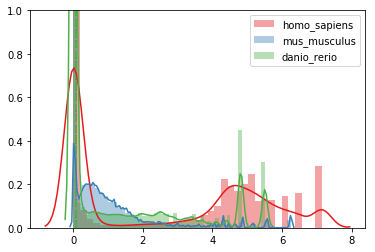

In [173]:
%%time

siglist_grouped_tf_idf = {}

siglist_species_tf_idf = []

fig, ax = plt.subplots()
colors = sns.color_palette("Set1")
for (species, species_sigs), color in zip(siglist_grouped.items(), colors):
    species_sigs = list(species_sigs)
    species_idf = idf.get_inverse_document_frequency(species_sigs)
    sns.distplot(pd.Series(species_idf), label=species, color=color)

    species_mean_idf_per_cell = idf.get_mean_idf_per_cell(species_sigs, 
                                                          species_idf)
    ymin, ymax = ax.get_ylim()
    ax.vlines(species_mean_idf_per_cell, ymin, ymax, 
              linestyle='--', color=color, linewidth=2)
    species_sigs_filtered_idf = [idf.filter_idf(x.minhash.get_mins(), 
                                       species_idf, species_mean_idf_per_cell) 
                                 for x in species_sigs]
    siglist_grouped_tf_idf[species] = species_sigs_filtered_idf
    siglist_species_tf_idf.extend(species_sigs_filtered_idf)
ax.legend()

ax.set(ylim=(0, 1))

In [177]:
from collections import Counter, defaultdict
from itertools import chain

hash_counter = pd.Series(Counter(chain(*[x.minhash.get_mins() for x in species_sigs])))
hash_counter.head()

419085876098808    246
426402945873716    246
546965526049676    246
591811589266028    246
600841627557681    242
dtype: int64

In [195]:
x = species_sigs[0]

In [197]:
# x.minhash.get_hashes()

In [193]:
hash_counter.describe()

count    87967.000000
mean       183.271636
std         97.085972
min          1.000000
25%         96.000000
50%        245.000000
75%        246.000000
max        246.000000
dtype: float64

In [189]:
hash_counter.shape

(87967,)

In [178]:
hash_counter.tail()

6235281696120896444    1
6280043063095090721    1
6297998350892250985    1
6298343442101120325    1
6300603135611003422    1
dtype: int64

In [185]:
hash_counter.rank(ascending=False)

419085876098808        21748.0
426402945873716        21748.0
546965526049676        21748.0
591811589266028        21748.0
600841627557681        54830.5
610207619962225        21748.0
790242877560330        21748.0
839526612265541        21748.0
842057698698632        21748.0
849270047806555        21748.0
934140807930689        46791.0
970695888941293        21748.0
1081118902867186       21748.0
1092650932175167       46791.0
1246737114549601       21748.0
1295189822047682       21748.0
1362176038085710       21748.0
1372019958054395       21748.0
1406918111307368       21748.0
1521252280030739       21748.0
1616990729675233       21748.0
1646437689023994       56944.5
1711422056803771       21748.0
1755865195985383       21748.0
1791957077728611       21748.0
1881084458082627       57406.0
1928471503237932       21748.0
2025742119878263       53519.0
2034762210722416       51404.5
2060087427738550       21748.0
                        ...   
6043632885340044513    86498.5
60502897

In [192]:
hash_counter.median()

245.0

In [191]:
hash_counter.mean()

183.271635954392

[Text(0, 0.5, 'frequency'), Text(0.5, 0, 'rank')]

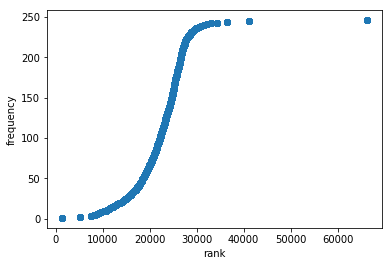

In [190]:
fig, ax = plt.subplots()
ax.scatter(hash_counter.rank(ascending=True), hash_counter)
ax.set(xlabel='rank', ylabel='frequency')

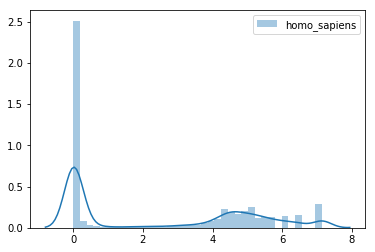

In [169]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
sns.distplot(pd.Series(species_idf), label=species)
ax.legend()


In [170]:
# species_idf

{419085876098808: 0.003969834510911016,
 426402945873716: 0.0007927071362389057,
 546965526049676: 0.0,
 591811589266028: 0.0,
 600841627557681: 0.01275934375375992,
 610207619962225: 0.0,
 790242877560330: 0.0,
 813281100256418: 0.05037620732506687,
 839526612265541: 0.008754532634247419,
 842057698698632: 0.004765696073014425,
 849270047806555: 0.0031746058407726395,
 934140807930689: 0.0023800090568113275,
 970695888941293: 0.0,
 1081118902867186: 0.0,
 1092650932175167: 0.013562234202350382,
 1246737114549601: 0.0015860431556347797,
 1289819540950378: 0.06633622690379613,
 1295189822047682: 0.0015860431556347797,
 1319881618925836: 0.146520067877969,
 1362176038085710: 0.003969834510911016,
 1372019958054395: 0.0,
 1406918111307368: 0.00795549144111468,
 1521252280030739: 0.0,
 1584822340379157: 0.147437920168198,
 1616990729675233: 0.00795549144111468,
 1646437689023994: 0.014365769802033681,
 1711422056803771: 0.0015860431556347797,
 1755865195985383: 0.0,
 1790373162729321: 0.07

In [137]:
siglist_species_tf_idf[:2]

[{5204943998223482884,
  3110567584024264724,
  2211557384986689562,
  4370912864077545504,
  5238057810998689824,
  4398976941976584229,
  3920098308085284913,
  3787220884793229362,
  1233385918368284726,
  4184415341305167932,
  5224203556642390080,
  5172082135223664705,
  1206122074062782537,
  2089412909466910795,
  3513180026320519252,
  4577426998028402774,
  2727384680683110494,
  4169084519798571116,
  4760144430445854831,
  5229001448589295729,
  5238052397596409986,
  4513609087555174539,
  5179544234070868117,
  3058861275512832157,
  3086807824709484701,
  5252586658968141983,
  2526883237822300322,
  3482527913440706730,
  527179942107545773,
  4509854201138806959,
  1791714382653292723,
  4695640082613469374,
  5192705122242855107,
  1199022932054245579,
  4315071802402308307,
  3783137575689617622,
  5161799114048897258,
  757266178409758960,
  2170835450168606969,
  3630332705709588730,
  4509909271447273726,
  4097972865669595393,
  4107362927886729481,
  24415067320

In [136]:
# siglist_grouped_tf_idf['danio_rerio']

In [48]:
jaccard_utils.jaccard_sigs_idf?

For each cell's

In [88]:
siglist_zebrafish_filtered_idf = [idf.filter_idf(x.minhash.get_mins(), 
                                       inverse_document_frequency, mean_idf_per_cell) for x in siglist_zebrafish]

In [91]:
siglist_zebrafish_filtered_idf_lengths = [len(x) for x in siglist_zebrafish_filtered_idf]
siglist_zebrafish_filtered_idf_lengths[:10]

[10090, 10545, 16491, 10037, 9550, 10811, 10272, 9641, 9603, 10660]

In [ ]:
%%time

n_jobs = 32

n = len(siglist_species_tf_idf)

iterator = itertools.combinations(range(n), range(n))


def jaccard_sigs_idf(i, j, hashlist):
    i_hashes = idf.filter_idf(hashlist[i],
                          inverse_document_frequency, mean_idf_per_cell)
    j_hashes = idf.filter_idf(hashlist[j],
                          inverse_document_frequency, mean_idf_per_cell)
    return estimate_jaccard(i_hashes, j_hashes)



In [138]:
%%time
values_idf = Parallel(n_jobs=n_jobs)(delayed(estimate_jaccard)(x, y) 
                                 for x, y in itertools.combinations(siglist_species_tf_idf, 2))

CPU times: user 57min 40s, sys: 3min 3s, total: 1h 43s
Wall time: 58min 20s


In [145]:
len(values_idf)

2053351

In [148]:
import numpy as np
from scipy.spatial.distance import squareform

similarities_idf = squareform(values_idf)
print(similarities_idf.shape)

# 'squareform' was made for *distance* matrices not *similarity*
# so need to replace diagonal values with 1.
# np.fill_digonal modifies 'similarities' in-place
np.fill_diagonal(similarities_idf, 1)
similarities_idf[:5,:5]

(2027, 2027)


array([[1.        , 0.7897018 , 0.78885427, 0.75081911, 0.59431525],
       [0.7897018 , 1.        , 0.85679612, 0.8101595 , 0.57524272],
       [0.78885427, 0.85679612, 1.        , 0.81239183, 0.56126687],
       [0.75081911, 0.8101595 , 0.81239183, 1.        , 0.56958096],
       [0.59431525, 0.57524272, 0.56126687, 0.56958096, 1.        ]])

In [147]:
sketch_id = 'molecule-protein_ksize-21_log2sketchsize-12'
s3_prefix = 's3://kmer-hashing/hematopoeisis/human_mouse_zebrafish'
original_similarities = pd.read_csv(f"{s3_prefix}/similarities_{sketch_id}.csv")
original_similarities.index = original_similarities.columns
print(original_similarities.shape)
original_similarities.head()

(2027, 2027)


,SRR5810887_pass,SRR4050686_pass,SRR4052884_pass,SRR4052773_pass,SRR4050466_pass,SRR5810899_pass,SRR4051107_pass,SRR4052957_pass,SRR4052835_pass,SRR4050631_pass,...,SRR4050668_pass,SRR4050478_pass,SRR4050667_pass,SRR4050898_pass,SRR4050542_pass,SRR4050595_pass,SRR4053003_pass,SRR4050848_pass,SRR4053137_pass,SRR5810792_pass
SRR5810887_pass,1.000000,0.010010,0.010254,0.010010,0.008545,0.038086,0.011230,0.008057,0.009277,0.009766,...,0.009521,0.001709,0.007812,0.009766,0.010986,0.009277,0.007812,0.010986,0.007568,0.051514
SRR4050686_pass,0.010010,1.000000,0.145996,0.142090,0.129150,0.008789,0.179443,0.046387,0.151367,0.147949,...,0.161865,0.004395,0.149414,0.185059,0.171631,0.158936,0.180664,0.166016,0.135986,0.021729
SRR4052884_pass,0.010254,0.145996,1.000000,0.135498,0.114258,0.010986,0.152832,0.062988,0.133301,0.143555,...,0.144531,0.007324,0.151367,0.149658,0.155762,0.146484,0.142334,0.144043,0.108887,0.020020
SRR4052773_pass,0.010010,0.142090,0.135498,1.000000,0.138428,0.010254,0.160645,0.059570,0.142578,0.136719,...,0.137939,0.006348,0.140869,0.163574,0.150146,0.140381,0.149414,0.145752,0.125732,0.019531
SRR4050466_pass,0.008545,0.129150,0.114258,0.138428,1.000000,0.011230,0.137207,0.050537,0.139893,0.120605,...,0.122803,0.006348,0.116699,0.150391,0.145508,0.129395,0.139160,0.138672,0.144043,0.023682


In [ ]:
original_similarities.groupby

In [154]:
names = [x.name() for x in siglist]

similarities_idf_df = pd.DataFrame(similarities_idf, index=names, columns=names)
print(similarities_idf_df.shape)
similarities_idf_df.head()

(2027, 2027)


,SRR4050503_pass,SRR4053175_pass,SRR4050393_pass,A6-B002775-3_39_F-1-1,SRR4050424_pass,SRR4050818_pass,SRR4050748_pass,N20-MAA000752-3_10_M-1-1,SRR4052938_pass,SRR4053041_pass,...,SRR4052842_pass,SRR4053006_pass,SRR4050476_pass,SRR4050735_pass,SRR5810715_pass,SRR4050956_pass,D2-B001717-3_38_F-1-1,SRR4052935_pass,SRR4050909_pass,SRR5810776_pass
SRR4050503_pass,1.000000,0.789702,0.788854,0.750819,0.594315,0.806720,0.799827,0.800832,0.800139,0.649785,...,0.064944,0.139879,0.050818,0.130405,0.156589,0.072179,0.137984,0.037726,0.126443,0.172093
SRR4053175_pass,0.789702,1.000000,0.856796,0.810160,0.575243,0.886096,0.888350,0.888523,0.886616,0.642164,...,0.065187,0.145111,0.051491,0.137483,0.165395,0.072295,0.145111,0.037968,0.127774,0.180132
SRR4050393_pass,0.788854,0.856796,1.000000,0.812392,0.561267,0.903533,0.913119,0.912637,0.908476,0.630495,...,0.065594,0.144514,0.051575,0.137764,0.166494,0.071824,0.143648,0.037902,0.126861,0.183974
A6-B002775-3_39_F-1-1,0.750819,0.810160,0.812392,1.000000,0.569581,0.837201,0.840138,0.839314,0.838794,0.629764,...,0.066218,0.145542,0.052940,0.135713,0.163132,0.073633,0.144163,0.039317,0.129160,0.179514
SRR4050424_pass,0.594315,0.575243,0.561267,0.569581,1.000000,0.540526,0.530623,0.531115,0.532848,0.615397,...,0.057066,0.112719,0.043139,0.109710,0.124958,0.061741,0.112947,0.029036,0.101545,0.135889


In [155]:
# x = siglist_species_tf_idf[0]
# x
# # x.name()

In [ ]:
range(3)

## Plot nearest neighbor graph and hope that the species signal is removed

In [158]:
metadata = pd.read_csv('s3://kmer-hashing/hematopoeisis/human_mouse_zebrafish/metadata_combined.csv', 
                       index_col=0)
print(metadata.shape)
metadata.head()

(2027, 8)


,cell_ontology_class,species,tissue,species_color,cell_ontology_class_color,run,source_name,cell_label
cell,,,,,,,,
A1-B001717-3_38_F-1-1,macrophage,mus_musculus,Kidney,#2ca02c,#cc7af4,NaN,NaN,macrophage
A10-B002775-3_39_F-1-1,endothelial cell,mus_musculus,Kidney,#2ca02c,#f77189,NaN,NaN,endothelial cell
A10-MAA000752-3_10_M-1-1,endothelial cell,mus_musculus,Kidney,#2ca02c,#f77189,NaN,NaN,endothelial cell
A11-MAA000801-3_11_M-1-1,kidney collecting duct epithelial cell,mus_musculus,Kidney,#2ca02c,#33b07a,NaN,NaN,kidney collecting duct epithelial cell
A12-B001717-3_38_F-1-1,macrophage,mus_musculus,Kidney,#2ca02c,#cc7af4,NaN,NaN,macrophage


In [160]:
from khtools import sourmash_utils
from khtools import knn

AttributeError: module 'khtools.knn' has no attribute 'build_graph_and_plot'

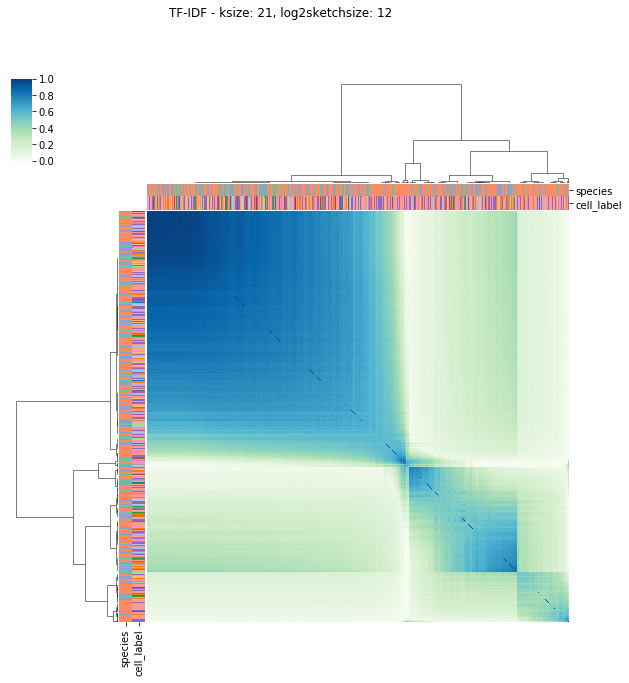

In [198]:
color_cols = ['species', 'cell_label',]
categories = metadata[color_cols]

palettes = dict(species='Set2', cell_label='tab20')

title =  title = f"TF-IDF - ksize: 21, log2sketchsize: 12"

s3_folder = 's3://olgabot-maca/nf-kmer-similarity/human_mouse_zebrafish/'
figure_folder = 's3://kmer-hashing/hematopoeisis/human_mouse_zebrafish/figures'

g = sourmash_utils.plaidplot(similarities_idf_df, 
                             metric='cosine', row_categories=categories, 
                         col_categories=categories, row_palette=palettes, col_palette=palettes)
g.fig.suptitle(title)
# png = f'{figure_folder}/{sketch_id}_plaidplot.png'
# g.savefig(png, dpi=150)

knn.build_graph_and_plot(similarities_idf_df, metadata, 
                     n_neighbors, color_cols, palettes, figure_folder, 
                     sketch_id, title)